In [82]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [83]:
%%cython

from __future__ import print_function
cimport cython
import numpy as np
cimport numpy as np
from libc.math cimport log, exp, ceil
from random import random
from collections import Counter

# create the memoized list of log(n!) up to some bound
cdef np.ndarray[np.float64_t, ndim=1] gen_lfact(int n):
    cdef int i
    cdef np.ndarray[np.float64_t, ndim=1] l = np.zeros((n+1,), dtype=np.float64)
    l[0] = 0
    for i in range(1, n+1):
        l[i] = l[i-1] + log(i)
    return l

cdef np.float64_t[:] lfact

# return log(T(n, m))
cdef double ltutte(int n, int m):
    if n < 0 or m < 0:
        return -float('inf')
    global lfact
    return (n+1)*log(2) + lfact[2*m+1] + lfact[2*m+3*n] - lfact[m]*2 - lfact[n] - lfact[2*m+2*n+2]

def sample_size(N):
    global lfact
    lfact = gen_lfact(5*N)
    probs = []
    sizes = []
    for n in range(0, N-1):
        m = N - n - 2
        probs.append(ltutte(n, m))
        sizes.append((n, m))
    high = max(probs)
    probs = [exp(p - high) for p in probs]
    total = sum(probs)
    probs = [p/total for p in probs]
    tot = 0
    for i in range(len(probs)):
        tot += probs[i]
    n, m = sizes[np.random.choice(N-1, p=probs)]
    return n, m

cdef long choose(long n, long m, double logremaining_graphs):
    cdef double r = random()
    cdef double total = 0.0
    cdef long d
    cdef long c
    cdef long k
    cdef long j
    cdef long count
    cdef double amt
    if m >= (n+1):
        for d in range(n+1):
            count = ((d+1)*m)/(n+1)
            for c in range(count):
                k = d + ((-n-1)*(c+1))/m + 1
                j = c
                amt = ltutte(k, j) + ltutte(n-k, m-j-1)
                amt = exp(amt - logremaining_graphs)
                total += 2*amt
                if n == n-k and m == m-j-1:
                    total -= amt
                if total >= r:
                    r = random()
                    if r < 0.5:
                        return (k << 32) + j
                    else:
                        return ((n-k) << 32) + m-j-1
    else:
        for d in range(m):
            count = ((d+1)*(n+1))/m
            for c in range(count):
                k = c
                j = d + ((-m)*(c+1))/(n+1) + 1
                amt = ltutte(k, j) + ltutte(n-k, m-j-1)
                amt = exp(amt - logremaining_graphs)
                total += 2*amt
                if n == n-k and m == m-j-1:
                    total -= amt
                if total >= r:
                    r = random()
                    if r < 0.5:
                        return (k << 32) + j
                    else:
                        return ((n-k) << 32) + m-j-1

cdef logmake_graph(internal, external):
    external_stack = [external]
    internal_stack = [internal]
    G = []
    cdef int n
    cdef int m
    cdef double logtotal_graphs
    cdef double logadd_internal
    cdef double logremaining_graphs
    while len(external_stack) > 0:
        internal = internal_stack.pop()
        external = external_stack.pop()
        n = len(internal)
        m = len(external)-2
        if n == 0 and m == 0:
            # nothing else to add
            continue
        logtotal_graphs = ltutte(n, m)
        logadd_internal = ltutte(n-1, m+1)
        if random() < exp(logadd_internal - logtotal_graphs):
            # add internal triangle
            triangle = (external[0], external[1], internal[0])
            G.append(triangle)
            external = np.insert(external, 1, internal[0])
            internal_stack.append(internal[1:])
            external_stack.append(external)
        else:
            logremaining_graphs = logtotal_graphs + log(1 - exp(logadd_internal - logtotal_graphs))
            k = choose(n, m, logremaining_graphs)
            # TODO: better canonical way to store a pair of ints?
            j = k & 0xFFFFFFFF
            k = k >> 32
            triangle = (external[0], external[1], external[j+2])
            G.append(triangle)
            left = np.append(external[j+2], external[1:j+2])
            right = np.append(external[0], external[j+2:])
            internal_stack.append(internal[:k])
            external_stack.append(left)
            internal_stack.append(internal[k:])
            external_stack.append(right)
    return G

def sample_graph(int n, int m):
    global lfact
    lfact = gen_lfact(5*n+5*m)
    cdef np.ndarray[np.int64_t, ndim=1] internal = np.arange(m+2, m+n+2)
    cdef np.ndarray[np.int64_t, ndim=1] external = np.arange(0, m+2)
    return logmake_graph(internal, external)

def distances(g, n, m, start):
    N = m + n + 2
    adj = [set() for _ in range(N)]
    for a, b, c in g:
        adj[a].add(b)
        adj[a].add(c)
        adj[b].add(a)
        adj[b].add(c)
        adj[c].add(a)
        adj[c].add(b)
    dists = -1 * np.ones(N, dtype=np.int32)
    fringe = set()
    fringe.add(start)
    distance = 0
    while len(fringe) > 0:
        _fringe = set()
        for vertex in fringe:
            dists[vertex] = distance
            for neighbor in adj[vertex]:
                if dists[neighbor] == -1 and neighbor not in fringe:
                    _fringe.add(neighbor)
        fringe = _fringe
        distance += 1
    return dists

def ball_size_old(g, n, m, start):
    N = m + n + 2
    adj = [set() for _ in range(N)]
    for a, b, c in g:
        adj[a].add(b)
        adj[a].add(c)
        adj[b].add(a)
        adj[b].add(c)
        adj[c].add(a)
        adj[c].add(b)
    fringe = set()
    seen = set()
    fringe.add(start)
    distance = 0
    while len(fringe) > 0:
        _fringe = set()
        for vertex in fringe:
            seen.add(vertex)
            for neighbor in adj[vertex]:
                if neighbor not in seen and neighbor not in fringe:
                    _fringe.add(neighbor)
        print(distance, len(fringe), len(seen), sep='\t')
        fringe = _fringe
        distance += 1

def ball_size(g, n, m, start):
    dists = distances(g, n, m, start)
    c = Counter(dists)
    total = 0
    for i in range(0, max(c.keys()) + 1):
        total += c[i]
        print(i, c[i], total, sep='\t')

def max_degree(g, n, m):
    degrees = Counter()
    for triple in g:
        degrees.update(triple)
    # count external vertices one more time
    degrees.update(range(m+2))
    print(sum(degrees.values()))
    return max(degrees.values())

def rw_dumb(g, n, m, start, iters):
    N = n + m + 2
    M = np.zeros((N, N))
    for a, b, c in g:
        M[a, b] += 1
        M[a, c] += 1
        M[b, a] += 1
        M[b, c] += 1
        M[c, a] += 1
        M[c, b] += 1
    for i in range(m+2):
        M[i, (i+1)%(m+2)] += 1
        M[(i+1)%(m+2), i] += 1
    M = M/2
    sums = np.sum(M, axis=0)
    A = M / sums[None, :]
    x = np.zeros(N)
    x[start] = 1
    l = []
    for t in range(iters):
        l.append(x[start])
        x = A.dot(x)
    return l

@cython.boundscheck(False)
def rw_sparse(g, n, m):
    N = n + m + 2
    pairs = Counter()
    for a, b, c in g:
        pairs[(a, b)] += 1
        pairs[(a, c)] += 1
        pairs[(b, a)] += 1
        pairs[(b, c)] += 1
        pairs[(c, a)] += 1
        pairs[(c, b)] += 1
    for i in range(m+2):
        pairs[(i, (i+1)%(m+2))] += 1
        pairs[((i+1)%(m+2), i)] += 1
    outdegrees = np.zeros(N)
    cdef np.ndarray[np.int32_t, ndim=1] v_out = np.zeros(len(pairs), dtype=np.int32)
    cdef np.ndarray[np.int32_t, ndim=1] v_in = np.zeros(len(pairs), dtype=np.int32)
    cdef np.ndarray[np.float64_t, ndim=1] probs = np.zeros(len(pairs), dtype=np.float64)
    i = 0
    for k in pairs:
        outdegrees[k[0]] += pairs[k]//2
    for k in pairs:
        v_out[i] = k[0]
        v_in[i] = k[1]
        probs[i] = pairs[k]/outdegrees[k[0]]/2
        i += 1
    return v_out, v_in, probs

def return_probabilities(g, n, m, start, iters):
    N = n + m + 2
    cdef np.ndarray[np.int32_t, ndim=1] v_out
    cdef np.ndarray[np.int32_t, ndim=1] v_in
    cdef np.ndarray[np.float64_t, ndim=1] probs
    v_out, v_in, probs = rw_sparse(g, n, m)
    cdef np.ndarray[np.float64_t, ndim=1] returns = np.zeros(iters, dtype=np.float64)
    cdef int t
    cdef int j
    cdef int transitions = len(v_out)
    cdef np.ndarray[np.float64_t, ndim=1] last = np.zeros(N, dtype=np.float64)
    last[start] = 1.0
    cdef np.ndarray[np.float64_t, ndim=1] cur = np.zeros(N, dtype=np.float64)
    for t in range(iters):
        returns[t] = last[start]
        for j in range(transitions):
            cur[v_in[j]] += last[v_out[j]] * probs[j]
        last = cur
        cur = np.zeros(N, dtype=np.float64)
    return returns
    
def speed(g, n, m, start, iters):
    N = n + m + 2
    cdef np.ndarray[np.int32_t, ndim=1] v_out
    cdef np.ndarray[np.int32_t, ndim=1] v_in
    cdef np.ndarray[np.float64_t, ndim=1] probs
    v_out, v_in, probs = rw_sparse(g, n, m)
    cdef np.ndarray[np.int32_t, ndim=1] dists = distances(g, n, m, start)
    cdef np.ndarray[np.float64_t, ndim=1] speeds = np.zeros(iters, dtype=np.float64)
    cdef int t
    cdef int j
    cdef int transitions = len(v_out)
    cdef np.ndarray[np.float64_t, ndim=1] last = np.zeros(N, dtype=np.float64)
    last[start] = 1.0
    cdef np.ndarray[np.float64_t, ndim=1] cur = np.zeros(N, dtype=np.float64)
    for t in range(iters):
        speeds[t] = (np.dot(last, dists))
        for j in range(transitions):
            cur[v_in[j]] += last[v_out[j]] * probs[j]
        last = cur
        cur = np.zeros(N, dtype=np.float64)
    return speeds

In [41]:
n, m = sample_size(N)
g = sample_graph(n, m)
from random import randrange
start = randrange(N)
x = speed(g, n, m, start, iters)
x

array([ 0.        ,  1.        ,  1.09259259,  1.39516461,  1.58608589,
        1.79390651,  1.97444693,  2.14581126,  2.30241677,  2.44756293,
        2.58110556,  2.70422804,  2.8175584 ,  2.92191032,  3.01797213,
        3.10642753,  3.18790064,  3.26297716,  3.33219537,  3.39605161,
        3.45500046,  3.509458  ,  3.55980406,  3.60638507,  3.64951667,
        3.68948628,  3.72655559,  3.76096281,  3.79292481,  3.82263912,
        3.85028564,  3.87602838,  3.90001688,  3.9223876 ,  3.94326515,
        3.96276336,  3.98098633,  3.99802934,  4.01397961,  4.0289171 ])

In [74]:
N = 100
iters = 1000
averages = {}
while N < 1000000//32:
    tot = 0.0
    count = 2000000 // N
    print N, count
    for i in range(count):
        n, m = sample_size(N)
        g = sample_graph(n, m)
        from random import randrange
        start = randrange(N)
        x = return_probabilities(g, n, m, start, iters)
        tot += x
    averages[N] = tot / count
    N *= 2

100 20000
200 10000
400 5000
800 2500
1600 1250
3200 625
6400 312
12800 156
25600 78


/homes/iws/jlee27/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in reciprocal
/homes/iws/jlee27/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide


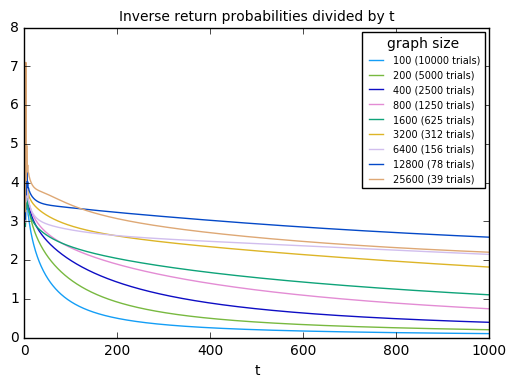

In [90]:
import matplotlib.pyplot as plt
plt.clf()
for key in sorted(averages.keys())[:]:
    plt.plot(averages[key][:]**(-1)/np.arange(0, len(averages[key])), label='%s (%s trials)' % (key, 1000000//key), color=np.random.rand(3,1))
plt.legend(fontsize=7, loc=1, title='graph size')
plt.xlabel('t')
plt.title('Inverse return probabilities divided by t', fontsize=10)
plt.show()

In [85]:
for i in range(len(averages[6400])):
    print'\t'.join(map(str, (i, averages[6400][i], averages[6400][i]**(-1)/i)))

0	1.0	inf
1	0.0	inf
2	0.167465797255	2.98568429014
3	0.0546577517372	6.09855551571
4	0.0713971599215	3.50153984101
5	0.0478830612059	4.17684239401
6	0.0460971689871	3.61555102686
7	0.0384199895373	3.71830249247
8	0.035241044172	3.54700046315
9	0.0314903840082	3.52841397812
10	0.0289555451092	3.45356993359
11	0.0266024065656	3.41732582294
12	0.024712563556	3.37210395613
13	0.0230403909247	3.3386185666
14	0.021607856592	3.3056759297
15	0.0203403027505	3.2775651122
16	0.0192222139049	3.25144649358
17	0.0182226787414	3.22803964481
18	0.0173259560991	3.20649291952
19	0.0165155084218	3.18679737875
20	0.0157797688281	3.16861422653
21	0.0151084348967	3.15181869893
22	0.0144933774752	3.13622863494
23	0.0139276377441	3.12172542599
24	0.0134054464333	3.10818941197
25	0.0129218767866	3.09552556959
26	0.0124727432968	3.08364708119
27	0.0120544439224	3.07247993151
28	0.0116638716007	3.06195806479
29	0.0112983264462	3.05202357046
30	0.0109554529547	3.04262484366
31	0.0106331852529	3.03371602666
32	0.

/homes/iws/jlee27/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


In [3]:
for i in xrange(10000000):
    g = sample_graph(5, 3)
    if g[0] == (0, 1, 5) and g[1] == (0, 5, 4) and g[2] == (4,5,3) and g[3] == (3, 5, 6) and g[4] == (3, 6, 5) and g[5] == (3,5,7) and g[6] == (3,7,8) and g[7] == (3,8,5):
        print g[8:]

[(3, 5, 2), (2, 5, 1), (5, 8, 7), (5, 7, 9), (5, 9, 7)]
[(3, 5, 2), (2, 5, 1), (2, 1, 9), (2, 9, 1), (5, 8, 7)]
[(3, 5, 1), (3, 1, 9), (3, 9, 2), (2, 9, 1), (5, 8, 7)]
[(3, 5, 2), (2, 5, 1), (5, 8, 9), (5, 9, 8), (5, 8, 7)]
[(3, 5, 9), (3, 9, 1), (3, 1, 2), (1, 9, 5), (5, 8, 7)]


KeyboardInterrupt: 

In [75]:
import pickle
with open('averages.pickle', 'wb') as f:
    pickle.dump(averages, f)

In [76]:
averages.keys()

[1600, 3200, 100, 25600, 200, 6400, 400, 12800, 800]

In [18]:
sum(i[-1] for i in xs)

6854.0670721263559

In [ ]:
xs = []
for N in range(100):
    if N % 1 == 0:
        print(N)
    n, m = sample_size(100000)
    g = sample_graph(n, m)
    x = speed(g, n, m, randrange(100000), 1000)
    xs.append(x)

0
1
2
3
4
5
6
7


In [21]:
sum(i[-1] for i in xs)

950.3012336866542

In [5]:
for _ in range(100):
    print sample_graph(0, 3)

[(0, 1, 4), (4, 1, 2), (4, 2, 3)]
[(0, 1, 2), (0, 2, 4), (4, 2, 3)]
[(0, 1, 4), (4, 1, 3), (3, 1, 2)]
[(0, 1, 4), (4, 1, 3), (3, 1, 2)]
[(0, 1, 2), (0, 2, 3), (0, 3, 4)]
[(0, 1, 4), (4, 1, 3), (3, 1, 2)]
[(0, 1, 4), (4, 1, 3), (3, 1, 2)]
[(0, 1, 4), (4, 1, 3), (3, 1, 2)]
[(0, 1, 2), (0, 2, 3), (0, 3, 4)]
[(0, 1, 2), (0, 2, 4), (4, 2, 3)]
[(0, 1, 3), (0, 3, 4), (3, 1, 2)]
[(0, 1, 4), (4, 1, 2), (4, 2, 3)]
[(0, 1, 2), (0, 2, 4), (4, 2, 3)]
[(0, 1, 2), (0, 2, 4), (4, 2, 3)]
[(0, 1, 2), (0, 2, 4), (4, 2, 3)]
[(0, 1, 2), (0, 2, 4), (4, 2, 3)]
[(0, 1, 4), (4, 1, 3), (3, 1, 2)]
[(0, 1, 3), (0, 3, 4), (3, 1, 2)]
[(0, 1, 4), (4, 1, 2), (4, 2, 3)]
[(0, 1, 4), (4, 1, 2), (4, 2, 3)]
[(0, 1, 4), (4, 1, 3), (3, 1, 2)]
[(0, 1, 3), (0, 3, 4), (3, 1, 2)]
[(0, 1, 4), (4, 1, 3), (3, 1, 2)]
[(0, 1, 4), (4, 1, 2), (4, 2, 3)]
[(0, 1, 4), (4, 1, 2), (4, 2, 3)]
[(0, 1, 2), (0, 2, 4), (4, 2, 3)]
[(0, 1, 2), (0, 2, 3), (0, 3, 4)]
[(0, 1, 2), (0, 2, 3), (0, 3, 4)]
[(0, 1, 4), (4, 1, 3), (3, 1, 2)]
[(0, 1, 3), (0

In [68]:
print '\n'.join(map(str, averages[6400]))

0.0
1.0
1.32052211294
1.59460528905
1.78478390682
1.94880030502
2.08623160271
2.20822218453
2.3172239442
2.41661337514
2.50804784225
2.59300017711
2.6724626863
2.74724094083
2.81795067311
2.88509238735
2.94907123197
3.01022348649
3.06883042899
3.12513058679
3.17932801417
3.23159892906
3.28209667759
3.330955673
3.37829448455
3.42421831906
3.46882102184
3.51218671123
3.55439112313
3.59550272699
3.63558365848
3.67469050464
3.71287496881
3.75018443714
3.78666246403
3.82234918992
3.85728170287
3.89149435266
3.92501902485
3.95788538087
3.99012106906
4.0217519108
4.05280206528
4.08329417573
4.11324949962
4.14268802488
4.17162857396
4.20008889713
4.22808575652
4.25563500178
4.28275163848
4.30944989011
4.33574325421
4.36164455348
4.38716598236
4.41231914946
4.43711511637
4.46156443326
4.48567717143
4.50946295332
4.53293098004
4.55609005677
4.57894861625
4.60151474039
4.62379618037
4.6458003752
4.66753446896
4.68900532685
4.71021955009
4.73118348978
4.75190325987
4.77238474925
4.79263363301
4.81